<a href="https://colab.research.google.com/github/educanto/keras_fashion_mnist/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports and functions**

In [239]:
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
import math

In [241]:
def plot_top_losses(loss_values, x_test, y_test, pred, k=9, figsize=(10,10)):
    top_k = loss_values.argsort()[-k:][::-1]
    print('top losses indexes: ', top_k)
    cols = math.ceil(math.sqrt(k))
    rows = math.ceil(k/cols)
    fig,axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle('Prediction/Actual/Loss/Prediction_Probability', weight='bold', size=14).set_position([.5, 1.05])
    i=0
    for index in top_k:
        image = x_test[index]
        actual = y_test[index]
        loss_value = loss_values[index]
        predicted = np.argmax(pred[index])
        prob = pred[index][predicted]
        title = f'{labels[predicted]}/{labels[actual]}/{loss_value:.2f}/{prob:.2f}'
        ax = axes.flat[i]
        i+=1
        image = np.squeeze(image)
        ax.imshow(image)
        ax.set_title(title)
    fig.tight_layout() 

# **Loading dataset**

In [242]:
dataset = keras.datasets.fashion_mnist
((x_train, y_train), (x_test, y_test)) = dataset.load_data()

labels = {0:'Camiseta', 1:'Calça', 2:'Pullover',3:'Vestido', 4:'Casaco', 5:'Sandália', 6:'Camisa', 7:'Tênis', 8:'Bolsa', 9:'Bota'}

# **Checking dataset**

In [243]:
print(x_train.shape)
print(x_test.shape)

print(y_train.min())
print(y_train.max())

(60000, 28, 28)
(10000, 28, 28)
0
9


# **Showing some data**

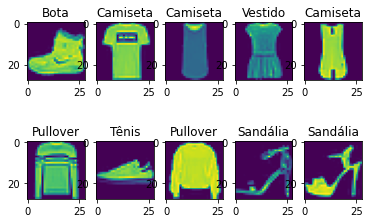

In [244]:
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i])
    plt.title(labels[y_train[i]])

# **Normalizing images**

In [245]:
x_train_norm = x_train/float(255)
x_test_norm = x_test/float(255)

# **Create, compile and train model**

In [246]:
model = keras.Sequential([ 
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(256, activation=tensorflow.nn.relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation=tensorflow.nn.softmax)
])

#keras.io/api/optimizers/adam/
adam = keras.optimizers.Adam(lr=0.001)

#keras.io/api/callbacks/
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=2),
             keras.callbacks.ModelCheckpoint(filepath='best_model.hdf5',
                                            monitor='val_loss',
                                            save_best_only=True)]

model.compile(optimizer=adam, 
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

historical = model.fit(x_train_norm, y_train, 
                       batch_size=480, 
                       epochs=10, 
                       validation_split=0.2,
                       callbacks=callbacks)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
100/100 [==============================] - 3s 23ms/step - loss: 0.7075 - accuracy: 0.7579 - val_loss: 0.4844 - val_accuracy: 0.8348
Epoch 2/10
100/100 [==============================] - 2s 16ms/step - loss: 0.4740 - accuracy: 0.8359 - val_loss: 0.4287 - val_accuracy: 0.8535
Epoch 3/10
100/100 [==============================] - 1s 15ms/step - loss: 0.4203 - accuracy: 0.8528 - val_loss: 0.4049 - val_accuracy: 0.8574
Epoch 4/10
100/100 [==============================] - 2s 16ms/step - loss: 0.3903 - accuracy: 0.8633 - val_loss: 0.3842 - val_accuracy: 0.8670
Epoch 5/10
100/100 [==============================] - 2s 15ms/step - loss: 0.3663 - accuracy: 0.8709 - val_loss: 0.3605 - val_accuracy: 0.8737
Epoch 6/10
100/100 [==============================] - 2s 16ms/step - loss: 0.3491 - accuracy: 0.8763 - val_loss: 0.3526 - val_accuracy: 0.8747
Epoch 7/10
100/100 [==============================] - 2s 15ms/step - loss: 0.3343 - accuracy: 0.8796 - val_loss: 0.3511 - val_accuracy: 0.8717

In [247]:
# print(historical.history.keys())
model.summary()
# weights, bias = model.layers[1].get_weights()
model.get_config()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               200960    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


{'name': 'sequential_7',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 28, 28),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'flatten_7_input'}},
  {'class_name': 'Flatten',
   'config': {'name': 'flatten_7',
    'trainable': True,
    'batch_input_shape': (None, 28, 28),
    'dtype': 'float32',
    'data_format': 'channels_last'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_14',
    'trainable': True,
    'dtype': 'float32',
    'units': 256,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_7',
    'trainable': True,
    'dtype': 'float32',
 

# **Save model**

In [248]:
model.save('model.h5')

# **Load model**

In [249]:
loaded_model = load_model('model.h5')

# **Results**

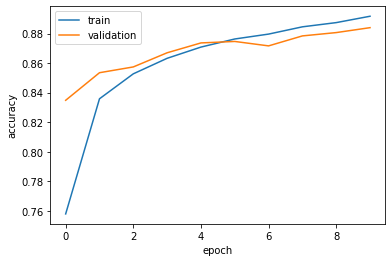

In [250]:
plt.plot(historical.history['accuracy'])
plt.plot(historical.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])


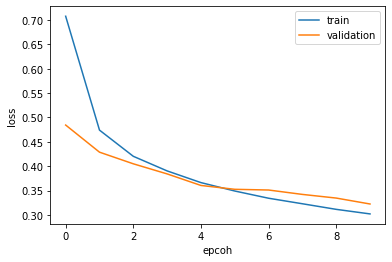

In [251]:
plt.plot(historical.history['loss'])
plt.plot(historical.history['val_loss'])
plt.xlabel('epcoh')
plt.ylabel('loss')
plt.legend(['train', 'validation'])

# **Testing loaded model**

In [252]:
test_pred = model.predict(x_test_norm)
print('test result:', np.argmax(test_pred[1]))
print('test image number:', y_test[1])

tests_saved_model = loaded_model.predict(x_test_norm)
print('test result saved model:', np.argmax(tests_saved_model[1]))
print('test image number:', y_test[1])

313/313 [==============================] - 1s 2ms/step
test result: 2
test image number: 2
313/313 [==============================] - 1s 2ms/step
test result saved model: 2
test image number: 2


# **Evaluating the model**

In [253]:
test_loss, acc_test = model.evaluate(x_test_norm, y_test)
print('test loss:', test_loss)
print('test accuracy:', acc_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3447 - accuracy: 0.8776
test loss: 0.3447411060333252
test accuracy: 0.8776000142097473


# **Plotting top losses**

In [254]:
loss = keras.losses.SparseCategoricalCrossentropy(reduction=keras.losses.Reduction.NONE)
loss_values = loss(y_test,test_pred).numpy()
print(loss_values)

[6.6502258e-02 9.3868105e-03 4.4583281e-05 ... 1.2360165e-02 8.0743607e-04
 2.7123710e-02]


top losses indexes:  [5512 3531  979 8763 2817 3132 5006  732 2396 5987 1300 7876 5470 8914
 2599 3262]


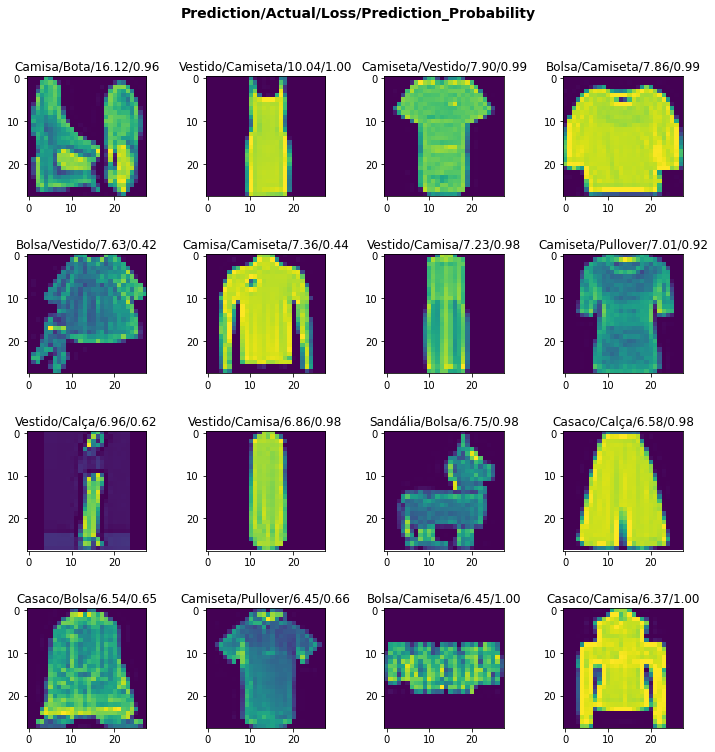

In [255]:
plot_top_losses(loss_values, x_test, y_test, test_pred, k=16)